In [30]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
import torch.utils.data.dataloader as Data
import torch.nn as nn
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [25]:
#对比展现原始图片和对抗样本图片
def show_images_diff(original_img,original_label,adversarial_img,adversarial_label):
    plt.figure()
    #归一化
    if original_img.any() > 1.0:
        original_img=original_img/255.0
    if adversarial_img.any() > 1.0:
        adversarial_img=adversarial_img/255.0

    plt.subplot(131)
    plt.title('Original')
    plt.imshow(original_img)
    plt.axis('off')

    plt.subplot(132)
    plt.title('Adversarial')
    plt.imshow(adversarial_img)
    plt.axis('off')

    plt.subplot(133)
    plt.title('Adversarial-Original')
    difference = adversarial_img - original_img
    #(-1,1)  -> (0,1)
    difference=difference / abs(difference).max()/2.0+0.5
    plt.imshow(difference,cmap=plt.cm.gray)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [26]:

#获取计算设备 默认是CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
#图像加载以及预处理
image_path="cropped_panda.jpg"
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (224, 224))
img = orig.copy().astype(np.float32)

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img /= 255.0
img = (img - mean) / std
img = img.transpose(2, 0, 1)

img=np.expand_dims(img, axis=0)

img = torch.from_numpy(img).to(device).float()
print(img.shape)

#使用预测模式 主要影响droupout和BN层的行为
model = models.alexnet(pretrained=True).to(device).eval()

orig_label=np.argmax(model(img).data.cpu().numpy())
print("orig_label={}".format(orig_label))

# print(img.data.cpu().numpy())
print(img.data.cpu().numpy().min(3).shape)

torch.Size([1, 3, 224, 224])
orig_label=388
(1, 3, 224)


In [27]:
#实现saliency_map
def saliency_map(F, x,t, mask):

        # pixel influence on target class
        F[0, t].backward(retain_graph=True)
        derivative=x.grad.data.cpu().numpy().copy()
        alphas = derivative * mask
        # pixel influence on sum of residual classes
        betas = -np.ones_like(alphas)

        sal_map = np.abs(alphas) * np.abs(betas) * np.sign(alphas * betas)
        # find optimal pixel & direction of perturbation
        idx = np.argmin(sal_map)

        #转换成(p1,p2)格式
        idx = np.unravel_index(idx, mask.shape)
        pix_sign = np.sign(alphas)[idx]

        return idx, pix_sign

In [28]:
#图像数据梯度可以获取
img.requires_grad = True

#设置为不保存梯度值 自然也无法修改
for param in model.parameters():
    param.requires_grad = False

epochs=500
#扰动系数
theta=0.3
#攻击目标
target_label=288
target=torch.Tensor([float(target_label)]).to(device).long()

loss_func = torch.nn.CrossEntropyLoss()
# the mask defines the search domain
# each modified pixel with border value is set to zero in mask
mask = np.ones_like(img.data.cpu().numpy())
#定义边界
max_=3.0
min_=-3.0
for epoch in range(epochs):

    # forward
    output = model(img)

    label=np.argmax(output.data.cpu().numpy())
    loss = loss_func(output, target)
    print("epoch={} label={} loss={}".format(epoch,label,loss))
    #如果定向攻击成功
    if label == target_label:
        break

    #梯度清零
    zero_gradients(img)
    idx, pix_sign=saliency_map(output, img,target_label, mask)
    # apply perturbation
    img.data[idx]=img.data[idx]+pix_sign * theta * (max_ - min_)

    #达到极限的点不再参与更新
    if (img.data[idx]<=min_) or (img.data[idx]>=max_):
        print("idx={} over {}".format(idx,img.data[idx]))
        mask[idx]=0
        img.data[idx]=np.clip(img.data[idx], min_, max_)

epoch=0 label=388 loss=12.659993171691895
epoch=1 label=388 loss=12.654679298400879
epoch=2 label=388 loss=12.708219528198242
epoch=3 label=388 loss=12.833199501037598
epoch=4 label=388 loss=12.845626831054688
epoch=5 label=388 loss=12.872472763061523
epoch=6 label=388 loss=12.894152641296387
epoch=7 label=388 loss=12.811473846435547
epoch=8 label=388 loss=12.740340232849121
epoch=9 label=388 loss=12.69425106048584
idx=(0, 1, 77, 145) over 4.312885284423828
epoch=10 label=388 loss=12.626453399658203
idx=(0, 1, 76, 144) over 4.085293769836426
epoch=11 label=388 loss=12.58331298828125
epoch=12 label=388 loss=12.656190872192383
epoch=13 label=388 loss=12.630523681640625
epoch=14 label=388 loss=12.605598449707031
epoch=15 label=388 loss=12.806636810302734
epoch=16 label=388 loss=12.72182559967041
epoch=17 label=388 loss=12.600480079650879
epoch=18 label=388 loss=12.476000785827637
epoch=19 label=388 loss=12.625906944274902
epoch=20 label=388 loss=12.694524765014648
epoch=21 label=388 loss=

(3, 224, 224)


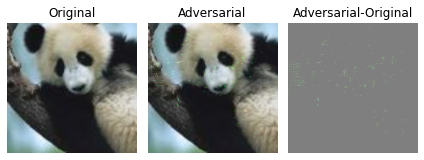

In [31]:
adv=img.data.cpu().numpy()[0]
print(adv.shape)
adv = adv.transpose(1, 2, 0)
adv = (adv * std) + mean
adv = adv * 256.0
adv = np.clip(adv, 0, 255).astype(np.uint8)
show_images_diff(orig,orig_label,adv,target_label)